In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import glob
import os

import pandas as pd
import xarray as xr
import pyomo.core as po
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import calliope
from calliope.core.util.dataset import split_loc_techs

idx = pd.IndexSlice

In [ ]:
calliope.set_log_verbosity()

In [7]:
model_files = glob.glob('../outputs/*.nc')
models = {
    os.path.basename(file).replace(".nc", ""): calliope.read_netcdf(file)
    for file in model_files
}

In [35]:
tech_groups = {
    'ac_ohl_mountain_transmission': 'transmission',
    'ac_ohl_transmission': 'transmission',
    'battery': 'storage',
    'dc_ohl_transmission': 'transmission',
    'dc_subsea_transmission': 'transmission',
    'dc_underground_transmission': 'transmission',
    'hydro_reservoir': 'hydro',
    'hydro_run_of_river': 'hydro',
    'hydrogen_storage': 'storage',
    'open_field_pv': 'pv',
    'pumped_hydro': 'storage',
    'methane_storage': 'storage',
    'roof_mounted_pv': 'pv',
    'wind_offshore': 'wind_off',
    'wind_onshore_competing': 'wind_on',
    'wind_onshore_monopoly': 'wind_on',
    'electrolysis': 'electrolysis',
    'biofuel_boiler': 'boiler',
    'methane_boiler': 'boiler',
    'electric_heater': 'electrified_heat',
    'hp': 'electrified_heat',
    'gas_hob': 'gas_cooking',
    'gas_hob': 'electrified_cooking',
    'waste_supply': 'waste_incineration',
    'ccgt': 'gas_powered_electricity',
    'heavy_transport_ev': 'EV transport',
    'heavy_transport_ice': 'ICE transport',
    'light_transport_ev': 'EV transport',
    'light_transport_ice': 'ICE transport',
    'biofuel_to_diesel': 'biofuel derived\nsynthetic fuel',
    'biofuel_to_liquids': 'biofuel derived\nsynthetic fuel',
    'biofuel_to_methane': 'biofuel derived\nsynthetic fuel',
    'hydrogen_to_diesel': 'hydrogen derived\nsynthetic fuel',
    'hydrogen_to_liquids': 'hydrogen derived\nsynthetic fuel',
    'hydrogen_to_methane': 'hydrogen derived\nsynthetic fuel'
}

In [33]:
energy_cap = (
    pd.concat(
        [split_loc_techs(v.results.energy_cap, return_as='Series') for v in models.values()], 
        axis=0, sort=True, names=['resolution_h'], 
        keys=[int(k.replace('model_out_', '').replace('h', '')) for k in models.keys()]
    )
    .where(lambda x: x > 1e-5).dropna()
    .sum(level=['resolution_h', 'techs'])
    .unstack('resolution_h')
)
energy_cap.index = energy_cap.index.str.split(':', expand=True)
energy_cap = energy_cap.groupby(level=0).sum()
energy_cap.loc[energy_cap.index.str.find('transmission') > -1] /= 2

In [37]:
energy_cap = energy_cap.groupby(tech_groups).sum()

<AxesSubplot:>

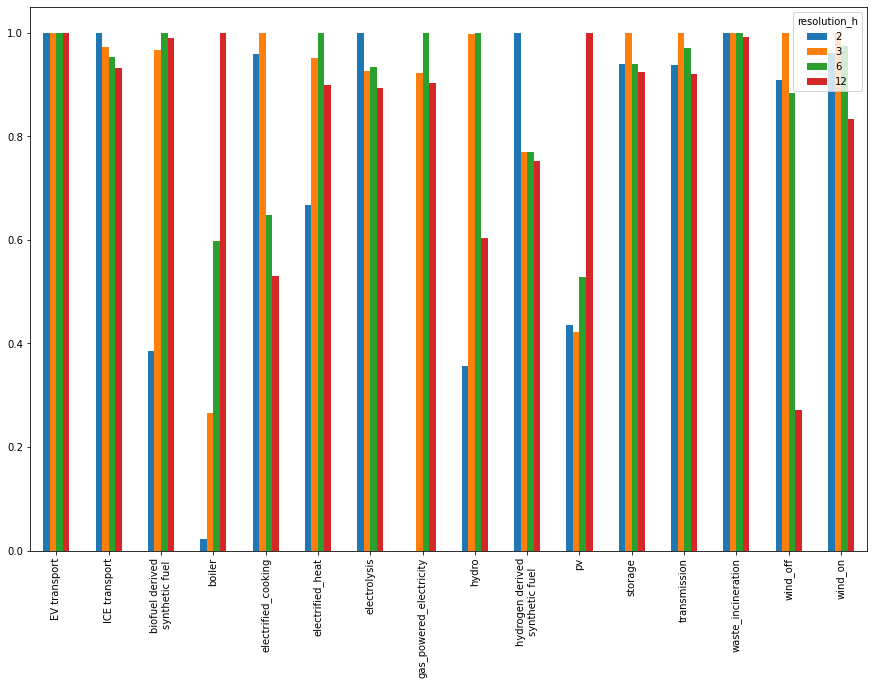

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
energy_cap.div(energy_cap.max(axis=1), axis=0).sort_index(axis=1).plot.bar(ax=ax)